<a href="https://colab.research.google.com/github/Md-Niaz/Hair-Fall-Prediction/blob/main/hair_fall_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# Neural Networks (Optional)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
# load the dataset
data = pd.read_csv('/content/Predict Hair Fall.csv')

# check the dimension of the dataset
num_row, num_col = data.shape
print('The dataset contains {} rows and {} columns.'.format(num_row, num_col))

# check the attributes in the dataset
attributes = list(data.columns)
print('\nAttributes in the dataset: ', ', '.join(attributes))

# view the first 5 rows of the dataset
data.head()

The dataset contains 999 rows and 13 columns.

Attributes in the dataset:  Id, Genetics, Hormonal Changes, Medical Conditions, Medications & Treatments, Nutritional Deficiencies , Stress, Age, Poor Hair Care Habits , Environmental Factors, Smoking, Weight Loss , Hair Loss


,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [ ]:
# summary of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Id                         999 non-null    int64 
 1   Genetics                   999 non-null    object
 2   Hormonal Changes           999 non-null    object
 3   Medical Conditions         999 non-null    object
 4   Medications & Treatments   999 non-null    object
 5   Nutritional Deficiencies   999 non-null    object
 6   Stress                     999 non-null    object
 7   Age                        999 non-null    int64 
 8   Poor Hair Care Habits      999 non-null    object
 9   Environmental Factors      999 non-null    object
 10  Smoking                    999 non-null    object
 11  Weight Loss                999 non-null    object
 12  Hair Loss                  999 non-null    int64 
dtypes: int64(3), object(10)
memory usage: 101.6+ KB


In [ ]:
# identify the data type for each independent variables

# binary data
binaryVar = ['Genetics','Hormonal Changes','Poor Hair Care Habits','Environmental Factors','Smoking','Weight Loss']
# categorical data
categoricalVar = ['Medical Conditions','Medications & Treatments','Nutritional Deficiencies']
# ordinal data
ordinalVar = ['Stress']
# continuous numeric data
continuousVar = ['Age']

In [ ]:
# exclude 'Id' from the analysis
data.drop(columns=['Id'], axis=1, inplace=True)

# remove the white space before and after the column names
colNames = [col.strip() for col in data.columns]
data.columns = colNames

# replace the value 'No Data' in the dataset to nan value
# imputation will be performed in the later stage
data.replace({'No Data': np.nan}, inplace=True)

# convert the data type of 'Stress' into ordinal level
desired_order_map = {'Low':0, 'Moderate':1, 'High':2}
data['Stress'] = data['Stress'].map(desired_order_map)

In [ ]:
train, test = train_test_split(data, test_size=0.2, stratify=data['Hair Loss'], shuffle=True, random_state=122)

# check the dimension of the training and test dataset
print('Dimension of training dataset: ', train.shape)
print('Dimension of test dataset: ', test.shape)

Dimension of training dataset:  (799, 12)
Dimension of test dataset:  (200, 12)


In [ ]:
# segregate the feature matrix and target vector from the training and test dataset
Xtrain = train.drop(columns=['Hair Loss'], axis=1)
ytrain = train['Hair Loss']

Xtest = test.drop(columns=['Hair Loss'], axis=1)
ytest = test['Hair Loss']

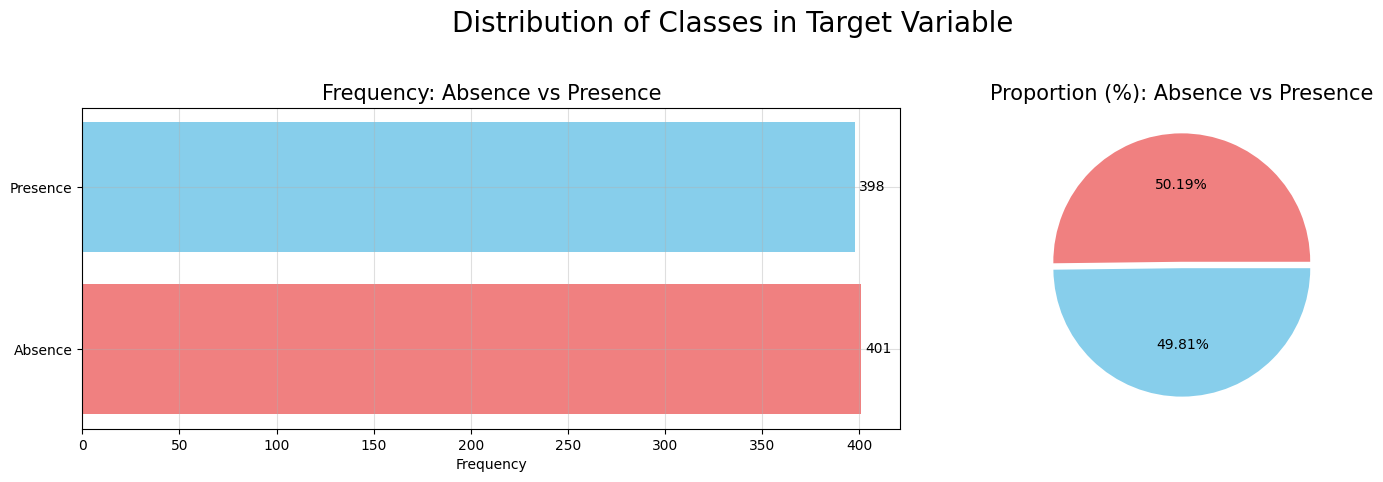

In [ ]:
# distribution of the classes in target
target = ytrain.value_counts()

figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=['Absence','Presence'], width=target.values, color=['lightcoral','skyblue'])
axes[0].grid(alpha=0.4)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Frequency: Absence vs Presence', fontsize=15)

for index, values in enumerate(target):
    axes[0].text(values+2, index, str(values), va='center')

axes[1].pie(target.values, autopct='%.2f%%', explode=[0.05,0], colors=['lightcoral','skyblue'])
axes[1].set_title('Proportion (%): Absence vs Presence', fontsize=15)

figure.suptitle('Distribution of Classes in Target Variable', fontsize=20)
plt.tight_layout(pad=2)
plt.show()


In [ ]:
# column names
colNames = Xtrain.columns

# create a SimpleImputer class
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

Xtrain_imputed = imp.fit_transform(Xtrain)                # imputation for training dataset
Xtrain = pd.DataFrame(Xtrain_imputed, columns=colNames)   # convert back to pandas dataframe

Xtest_imputed = imp.transform(Xtest)                      # imputation for test dataset
Xtest = pd.DataFrame(Xtest_imputed, columns=colNames)     # convert back to pandas dataframe

In [ ]:
# perform ordinal encoding to variable 'stress'
ordinal_encoder = OrdinalEncoder()
stress_train_encoded = ordinal_encoder.fit_transform(Xtrain['Stress'].to_frame())
stress_test_encoded = ordinal_encoder.transform(Xtest['Stress'].to_frame())

In [ ]:
# helper function to perform one hot encoding for binary and caegorical features in training and test dataset
def onehotencoding(features, train, test):
    training_list = []
    test_list = []

    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    for feat in features:
        # Create OneHotEncoder object
        encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

        # Fit and transform the training data
        feat_train_encoded = encoder.fit_transform(train[feat].to_frame())
        feat_train_df = pd.DataFrame(feat_train_encoded, columns=encoder.get_feature_names_out())

        # Transform the test data
        feat_test_encoded = encoder.transform(test[feat].to_frame())
        feat_test_df = pd.DataFrame(feat_test_encoded, columns=encoder.get_feature_names_out())

        # Append the DataFrames to lists
        training_list.append(feat_train_df)
        test_list.append(feat_test_df)

    return training_list, test_list

In [ ]:
# list of features to be encoded with OneHotEncoding technique
onehot_features = binaryVar + categoricalVar

# encode the categorical features in train and test dataset
oh_encoded_features = onehotencoding(onehot_features, Xtrain, Xtest)

# convert the encoded training and test data into dataframes
oh_encoded_train = oh_encoded_features[0]
Xtrain_processed = pd.concat(oh_encoded_train, axis=1)
Xtrain_processed['Stress'] = stress_train_encoded
Xtrain_processed['Age'] = Xtrain['Age']

oh_encoded_test = oh_encoded_features[1]
Xtest_processed = pd.concat(oh_encoded_test, axis=1)
Xtest_processed['Stress'] = stress_test_encoded
Xtest_processed['Age'] = Xtrain['Age']

In [ ]:
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain_processed)
Xtrain_scaled = pd.DataFrame(Xtrain_scaled, columns=Xtrain_processed.columns)

Xtest_scaled = scaler.transform(Xtest_processed)
Xtest_scaled = pd.DataFrame(Xtest_scaled, columns=Xtrain_processed.columns)

In [ ]:
# helper function to evaluate model performance
def modelPerformance(Xtrain, ytrain, Xtest, ytest, model):
    # predict classes
    ypred_train = model.predict(Xtrain)
    ypred_test = model.predict(Xtest)

    # predict class probabilities
    ypred_train_proba = model.predict_proba(Xtrain)
    ypred_test_proba = model.predict_proba(Xtest)

    labels = ['Absence','Presence']

    # classification report
    report_train = classification_report(ytrain, ypred_train, target_names=labels)
    print('Classification Report - Training Data: ')
    print(report_train)

    report_test = classification_report(ytest, ypred_test, target_names=labels)
    print('ClassificationReport - Test Data: ')
    print(report_test)

    # ROC curve
    fpr_train, tpr_train, _ = roc_curve(ytrain, ypred_train_proba[:,1])
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(ytest, ypred_test_proba[:,1])
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='indigo', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='indianred', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
    plt.legend(loc='lower right')
    plt.show()

    # confusion matrix
    cm_train = confusion_matrix(ytrain, ypred_train, normalize='true')
    cm_test = confusion_matrix(ytest, ypred_test, normalize='true')

    figure, axes = plt.subplots(1,2, figsize=(13,5))
    sns.heatmap(cm_train, annot=True, xticklabels=labels, yticklabels=labels, cmap='BuPu', cbar=False, ax=axes[0])
    axes[0].set_title('Training', fontsize=15)
    sns.heatmap(cm_test, annot=True, xticklabels=labels, yticklabels=labels, cmap='BuPu', cbar=False, ax=axes[1])
    axes[1].set_title('Test', fontsize=15)
    figure.suptitle('Confusion Matrix', fontsize=20)
    plt.tight_layout(pad=2)
    plt.show()

In [ ]:
# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)

# fitted the tree model with training data
tree.fit(Xtrain_scaled, ytrain)


DecisionTreeClassifier(random_state=122)

Classification Report - Training Data: 
              precision    recall  f1-score   support

     Absence       1.00      1.00      1.00       401
    Presence       1.00      1.00      1.00       398

    accuracy                           1.00       799
   macro avg       1.00      1.00      1.00       799
weighted avg       1.00      1.00      1.00       799

ClassificationReport - Test Data: 
              precision    recall  f1-score   support

     Absence       0.48      0.50      0.49       101
    Presence       0.47      0.44      0.46        99

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



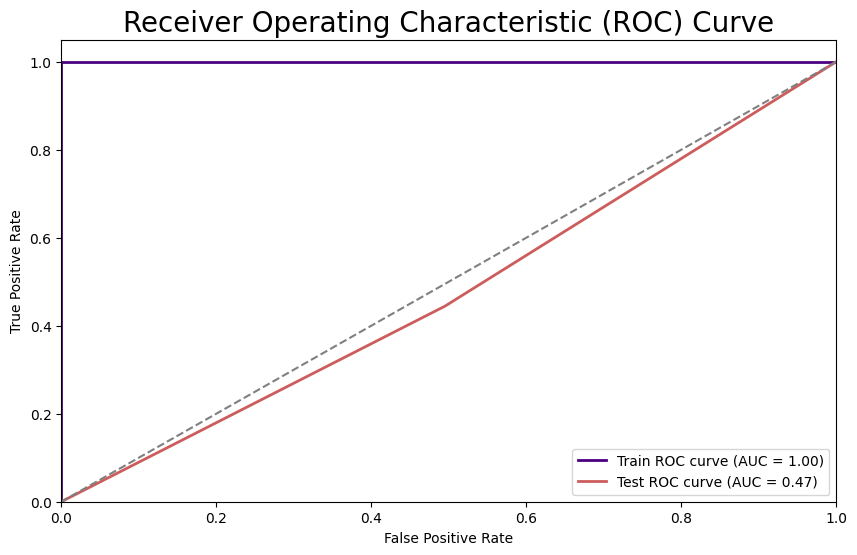

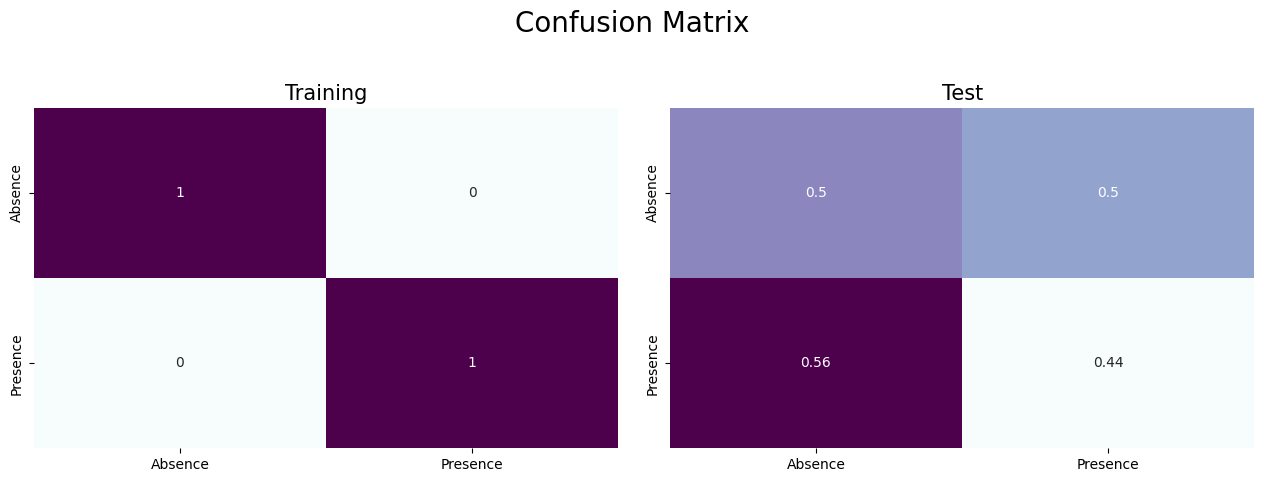

In [ ]:
# performance of model fitted with all features without hyperparameter tuning
modelPerformance(Xtrain_scaled, ytrain, Xtest_scaled, ytest, tree)

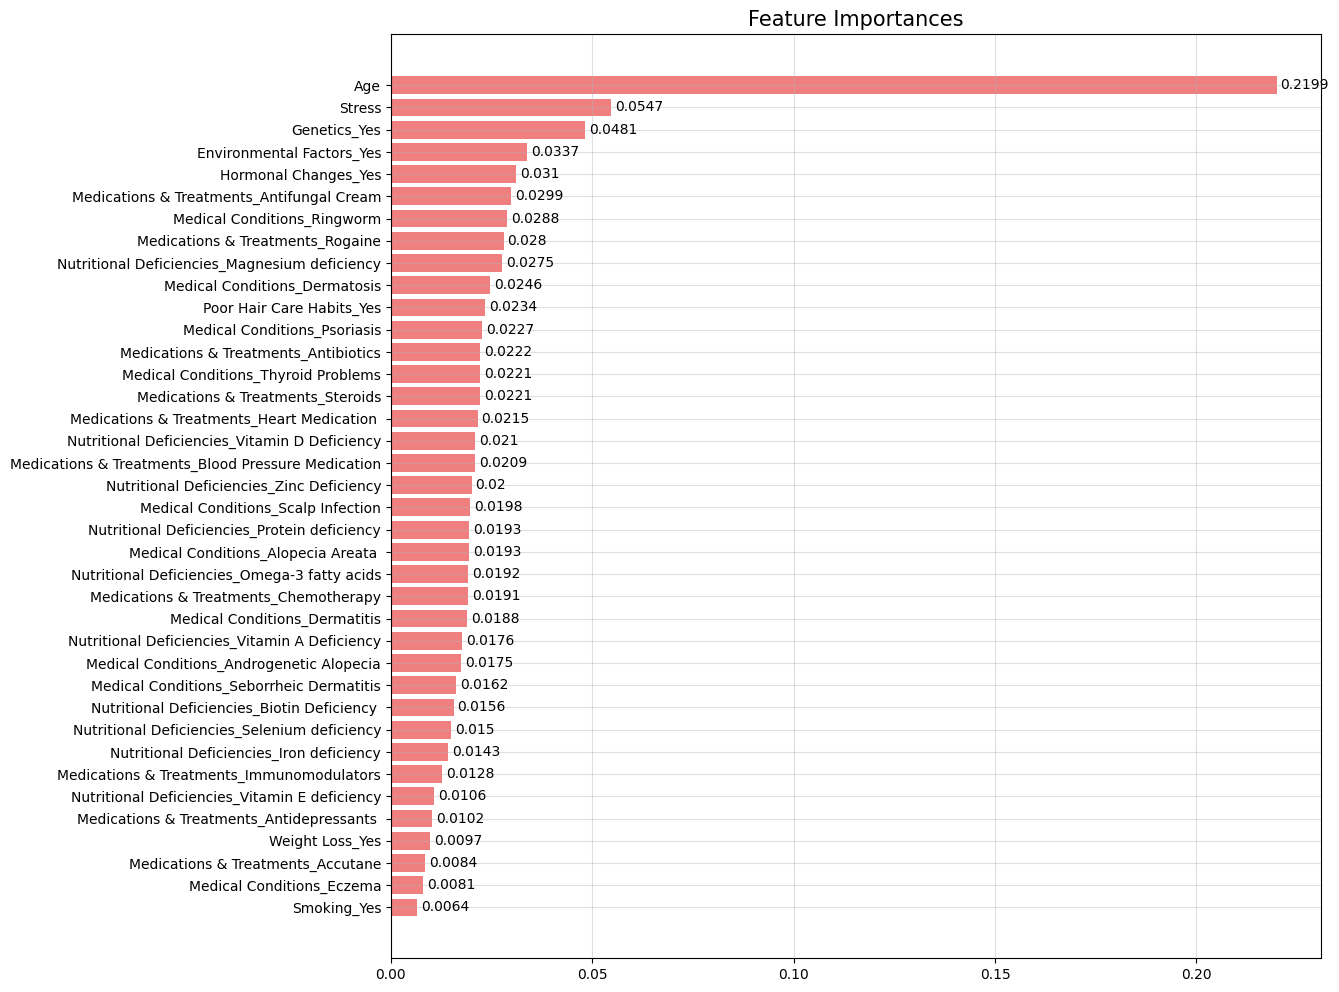

In [ ]:
# extract the feature importances from model 1
featureImportances = tree.feature_importances_

# create a pandas series for the feature importances
feat_imp = pd.Series(featureImportances, index=tree.feature_names_in_).sort_values(ascending=True)

plt.figure(figsize=(12,12))
plt.barh(y=feat_imp.index, width=feat_imp.values, color='lightcoral')

for index, values in enumerate(feat_imp):
    plt.text(values+0.001, index, str(round(values,4)), va='center')


plt.grid(alpha=0.4)
plt.title('Feature Importances', fontsize=15)
plt.show()

In [ ]:
# subset the features that meet threshold values for selection
selected_feats = list(feat_imp[feat_imp.values > 0.08].index)

In [ ]:
# create a Decision Tree Classifier
tree_base = DecisionTreeClassifier(random_state=122)

# fitted the tree model with selected features
tree_base.fit(Xtrain_scaled[selected_feats], ytrain)

DecisionTreeClassifier(random_state=122)

Classification Report - Training Data: 
              precision    recall  f1-score   support

     Absence       0.58      0.66      0.61       401
    Presence       0.60      0.52      0.55       398

    accuracy                           0.59       799
   macro avg       0.59      0.59      0.58       799
weighted avg       0.59      0.59      0.58       799

ClassificationReport - Test Data: 
              precision    recall  f1-score   support

     Absence       0.53      0.56      0.55       101
    Presence       0.53      0.49      0.51        99

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



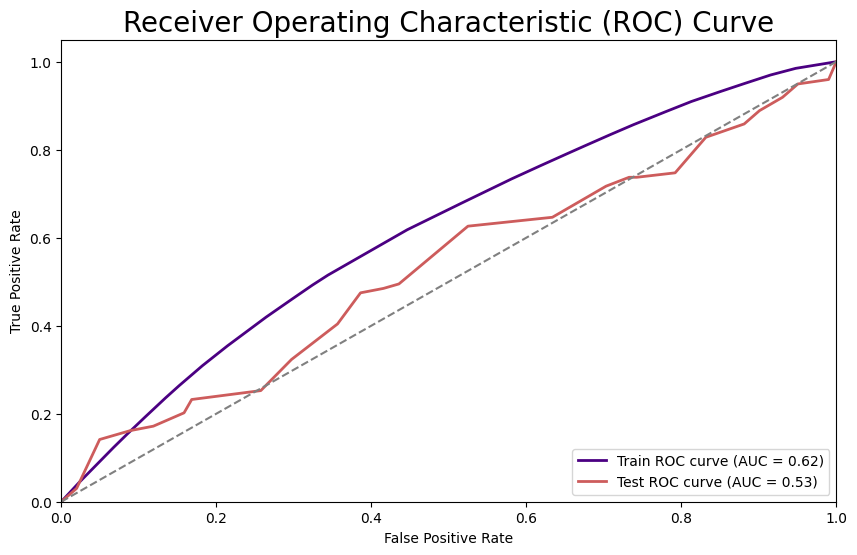

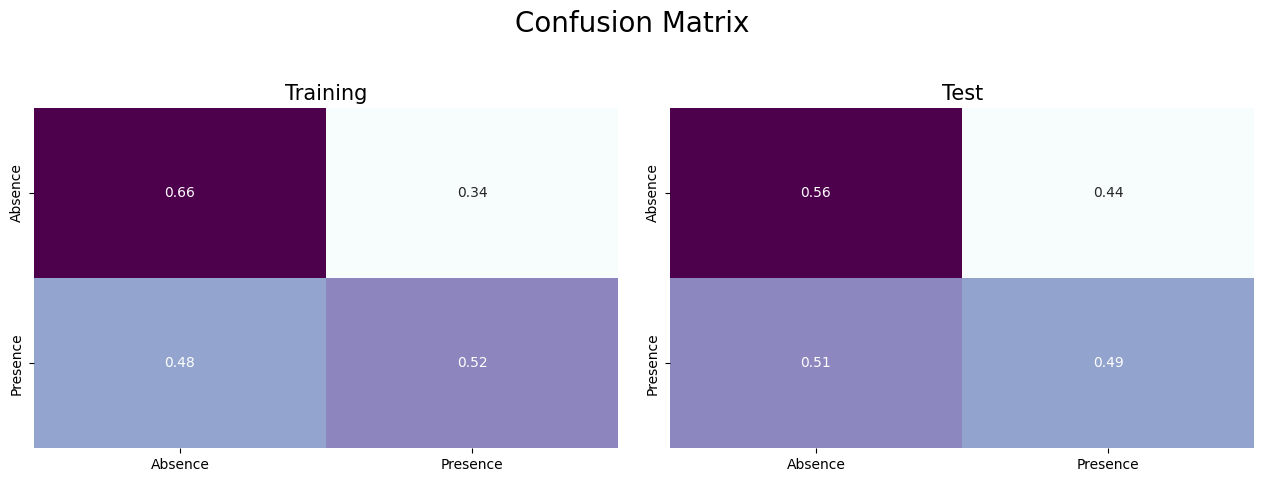

In [ ]:
# performance of model fitted with selected features without hyperparameter tuning
modelPerformance(Xtrain_scaled[selected_feats], ytrain, Xtest_scaled[selected_feats], ytest, tree_base)

In [ ]:
# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain_scaled[selected_feats], ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best AUROC: ', grid_search_tree.best_score_)

# get the best model
tree_tuned = grid_search_tree.best_estimator_

Best Parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
Best AUROC:  0.5364428108884202


Classification Report - Training Data: 
              precision    recall  f1-score   support

     Absence       0.56      0.69      0.62       401
    Presence       0.59      0.44      0.51       398

    accuracy                           0.57       799
   macro avg       0.57      0.57      0.56       799
weighted avg       0.57      0.57      0.56       799

ClassificationReport - Test Data: 
              precision    recall  f1-score   support

     Absence       0.53      0.65      0.59       101
    Presence       0.54      0.41      0.47        99

    accuracy                           0.54       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.54      0.54      0.53       200



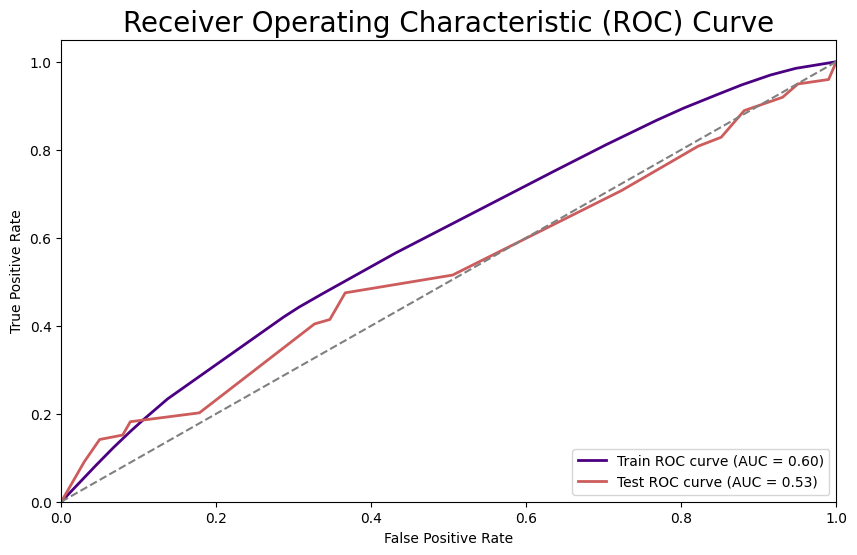

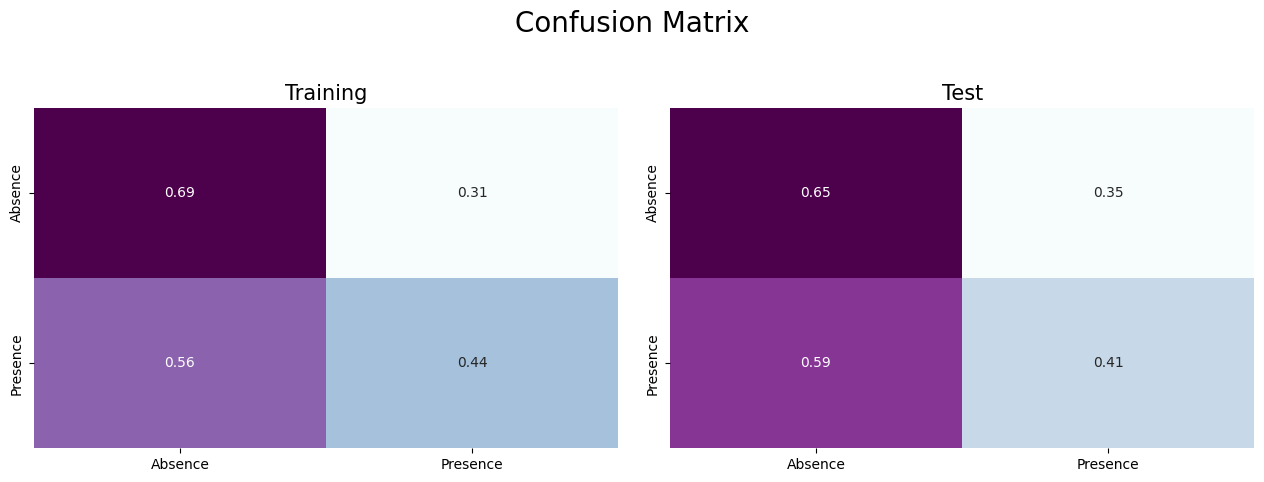

In [ ]:
# performance of model fitted with selected features with hyperparameter tuning
modelPerformance(Xtrain_scaled[selected_feats], ytrain, Xtest_scaled[selected_feats], ytest, tree_tuned)

In [ ]:
# Example data for context
X = np.random.rand(100, 10)  # Example feature data
y = np.random.randint(0, 2, 100)  # Example target data
SEED = 42

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Standardizing the data
scaler = StandardScaler()
X_train_prep = scaler.fit_transform(X_train)
X_test_prep = scaler.transform(X_test)

# Hyperparameter tuning for models
param_grid = {
    "Logistic Regression": {
        'model': LogisticRegression(random_state=SEED),
        'params': {'C': [0.1, 1, 10]}
    },
    "K-Nearest Neighbors": {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7]}
    },
    "Support Vector Classifier": {
        'model': SVC(probability=True, random_state=SEED),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    "Decision Tree": {
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {'max_depth': [None, 10, 20, 30]}
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=SEED),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    },
    "XGBoost": {
        'model': XGBClassifier(random_state=SEED),
        'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    }
}

# Dictionary to store results
results = {}

# Train, tune, and evaluate each model using GridSearchCV
best_estimators = {}
for model_name, config in param_grid.items():
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train_prep, y_train)

    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train_prep)
    y_pred_test = best_model.predict(X_test_prep)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    results[model_name] = {
        "Training Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Best Params": grid_search.best_params_
    }
    best_estimators[model_name] = best_model

# Define the base learners for the stacking classifier
base_learners = [(name, model) for name, model in best_estimators.items()]

# Define the final estimator
final_estimator = LogisticRegression(random_state=SEED)

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=final_estimator, cv=5)

# Train the stacking classifier
stacking_clf.fit(X_train_prep, y_train)

# Evaluate the stacking classifier
y_pred_train_stack = stacking_clf.predict(X_train_prep)
y_pred_test_stack = stacking_clf.predict(X_test_prep)

train_accuracy_stack = accuracy_score(y_train, y_pred_train_stack)
test_accuracy_stack = accuracy_score(y_test, y_pred_test_stack)

results["Stacking Classifier"] = {
    "Training Accuracy": train_accuracy_stack,
    "Test Accuracy": test_accuracy_stack,
    "Best Params": "N/A"  # Stacking does not have hyperparameters like the others
}

# Find the best model based on test accuracy
best_model_name = max(results, key=lambda x: results[x]["Test Accuracy"])
best_model_accuracy = results[best_model_name]["Test Accuracy"]

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Test Accuracy: {metrics['Test Accuracy']}")
    print(f"  Best Params: {metrics['Best Params']}")
    print()

print(f"The best model is {best_model_name} with a Test Accuracy of {best_model_accuracy}")



Logistic Regression:
  Test Accuracy: 0.45
  Best Params: {'C': 1}

K-Nearest Neighbors:
  Test Accuracy: 0.65
  Best Params: {'n_neighbors': 7}

Support Vector Classifier:
  Test Accuracy: 0.8
  Best Params: {'C': 1, 'kernel': 'rbf'}

Decision Tree:
  Test Accuracy: 0.45
  Best Params: {'max_depth': None}

Random Forest:
  Test Accuracy: 0.6
  Best Params: {'max_depth': None, 'n_estimators': 100}

XGBoost:
  Test Accuracy: 0.6
  Best Params: {'learning_rate': 0.01, 'n_estimators': 50}

Stacking Classifier:
  Test Accuracy: 0.9
  Best Params: N/A

The best model is Stacking Classifier with a Test Accuracy of 0.9
